# GAN Project

### Question 2
### GANs 

Now we will implement a DC-GAN on the CIFAR10 dataset. Let us start by loading the data.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchvision.utils import save_image
from scipy.stats import entropy
from torchvision.models import inception_v3
import torch.nn.functional as F
import math

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
batch_size = 100
epochs = 10
latent_dim = 100
lr = 0.0002
beta1 = 0.5

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

Files already downloaded and verified


Now let us make the DC-GAN model which will be trained on the CIFAR10 dataset

In [89]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(

            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.main(x)
        return x.view(-1, 1)


Now let us train our model.

In [90]:
generator = Generator()
discriminator = Discriminator()

criterion = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

losses_G = []
losses_D = []

In [91]:
real_labels = torch.ones(batch_size, 1)
fake_labels = torch.zeros(batch_size, 1)

for epoch in range(epochs):
    for i, (image, label) in enumerate(dataloader):

        # Discriminator Optimization
        optimizer_D.zero_grad()
        real_output = discriminator(image)
        real_loss = criterion(real_output, real_labels[:len(real_output)])

        noise = torch.randn(batch_size, latent_dim, 1, 1)
        fake_data = generator(noise)
        fake_output = discriminator(fake_data.detach())
        fake_loss = criterion(fake_output, fake_labels[:len(fake_output)])

        total_loss_d = fake_loss + real_loss
        total_loss_d.backward()
        optimizer_D.step()

        #Generator Optimization
        optimizer_G.zero_grad()
        fake_output = discriminator(fake_data)
        gen_loss = criterion(fake_output, real_labels[:len(fake_output)])
        gen_loss.backward()
        optimizer_G.step()

        losses_G.append(gen_loss.item())
        losses_D.append(total_loss_d.item())

        if (i+1)%34 == 0:
            print(f'Epoch [{epoch}/{epochs}], Step [{i+1}/{len(dataloader)}] - Discriminator Loss: {total_loss_d.item():.4f}, Generator Loss: {gen_loss.item():.4f}')

Epoch [0/10], Step [34/782] - Discriminator Loss: 0.1176, Generator Loss: 8.5674
Epoch [0/10], Step [68/782] - Discriminator Loss: 0.1888, Generator Loss: 14.1973
Epoch [0/10], Step [102/782] - Discriminator Loss: 0.5345, Generator Loss: 13.4500
Epoch [0/10], Step [136/782] - Discriminator Loss: 0.6037, Generator Loss: 2.9062
Epoch [0/10], Step [170/782] - Discriminator Loss: 0.2915, Generator Loss: 8.0398
Epoch [0/10], Step [204/782] - Discriminator Loss: 1.0857, Generator Loss: 5.8332
Epoch [0/10], Step [238/782] - Discriminator Loss: 0.2862, Generator Loss: 3.6200
Epoch [0/10], Step [272/782] - Discriminator Loss: 0.7051, Generator Loss: 3.9382
Epoch [0/10], Step [306/782] - Discriminator Loss: 0.4352, Generator Loss: 3.2039
Epoch [0/10], Step [340/782] - Discriminator Loss: 0.7846, Generator Loss: 2.6348
Epoch [0/10], Step [374/782] - Discriminator Loss: 0.7831, Generator Loss: 4.1430
Epoch [0/10], Step [408/782] - Discriminator Loss: 0.3702, Generator Loss: 3.0120
Epoch [0/10], St

Now let us plot the losses.

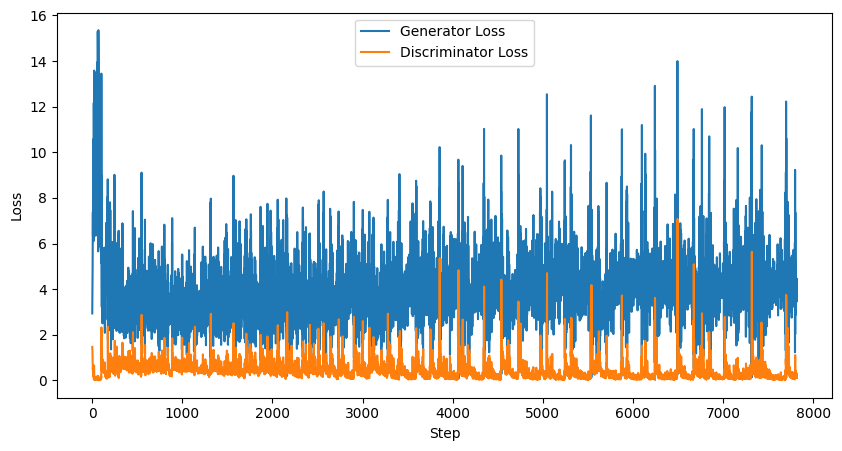

In [92]:
plt.figure(figsize=(10, 5))
plt.plot(losses_G, label='Generator Loss')
plt.plot(losses_D, label='Discriminator Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()

Now let us generate 10 images using the generator that we trained.

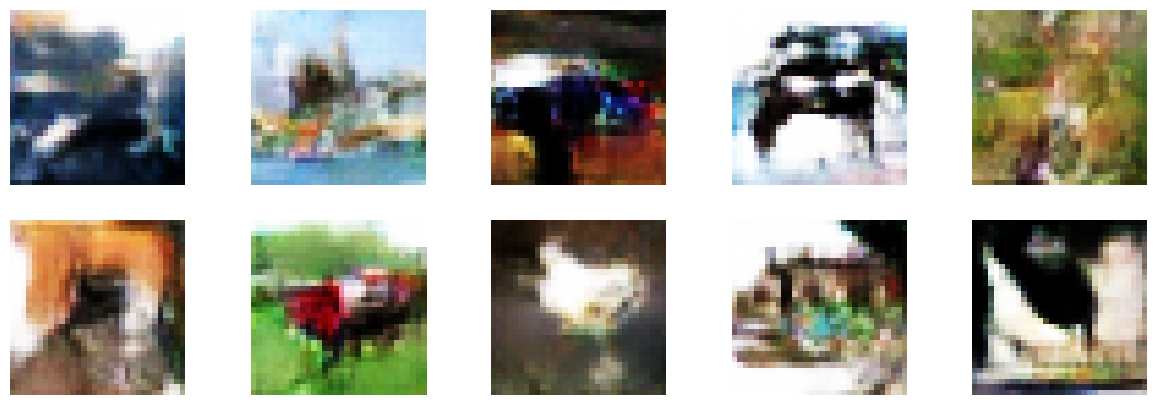

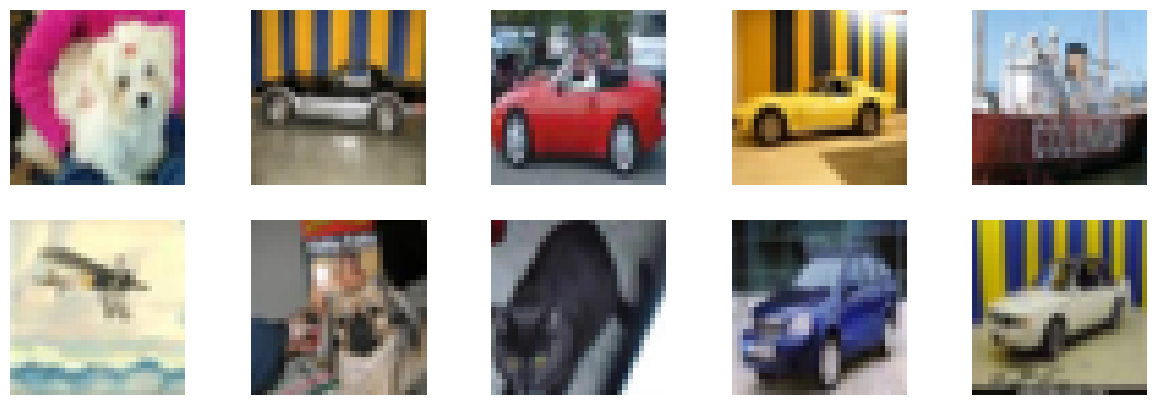

In [134]:
with torch.no_grad():
    z = torch.randn(10, latent_dim, 1, 1)
    images = generator(z)

fig, axes = plt.subplots(2, 5, figsize = (15, 5))

for i, img in enumerate(images):
    img = img.numpy().transpose((1, 2, 0))
    img = 0.5 * img + 0.5
    img = np.clip(img, 0, 1)
    if i < 5:
        x = 0
        y = i
    else:
        x = 1
        y = i - 5


    axes[x, y].imshow(img)
    axes[x, y].axis('off')

X, Y = next(iter(dataloader))
fig, axes = plt.subplots(2, 5, figsize = (15, 5))

for i, img in enumerate(X[:10]):
    img = img.numpy().transpose((1, 2, 0))
    img = 0.5 * img + 0.5
    img = np.clip(img, 0, 1)
    if i < 5:
        x = 0
        y = i
    else:
        x = 1
        y = i - 5


    axes[x, y].imshow(img)
    axes[x, y].axis('off')

Now let us write the function which allows us to calculate the inception scores

In [16]:
def calculate_inception_score(generated_images, num_splits=10):
    inception_model = inception_v3(pretrained=True, transform_input=False).eval()

    transform = transforms.Compose([
        lambda x: transforms.ToPILImage()(x.squeeze(0)),
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
    ])

    scores = []
    batch_size = generated_images.size(0)

    for i in range(num_splits):
        start_idx = i * (batch_size // num_splits)
        end_idx = (i + 1) * (batch_size // num_splits)

        batch = generated_images[start_idx:end_idx]
        batch = transform(batch)

        with torch.no_grad():
            preds = inception_model(batch.unsqueeze(0))

        preds = torch.nn.functional.softmax(preds, dim=1)

        kl_divergence = entropy(torch.Tensor(preds.numpy().mean(axis=0)), axis=0)
        scores.append(kl_divergence)

    inception_score = torch.Tensor(scores).mean()

    return inception_score.item()

In [ ]:
inception_score = calculate_inception_score(images)
print(f'Inception Score is: {inception_score}')